## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special, scipy.signal
import sys
import hickle, cPickle

sys.path.insert(0, '../../../getConversionFactors/')
sys.path.insert(0, '../../../csv/')

import plot_csv_support as pcs
import getConversionFactors as gcf
import getConversionFactors_poly as gcfp
import plotTemperatureToT as pttt
import ToTtoEnergy as tte

reload(pcs)
reload(gcf)
reload(gcfp)

<module 'getConversionFactors_poly' from '../../../getConversionFactors/getConversionFactors_poly.pyc'>

## Temperature Calibration Files

../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_75keV.hck


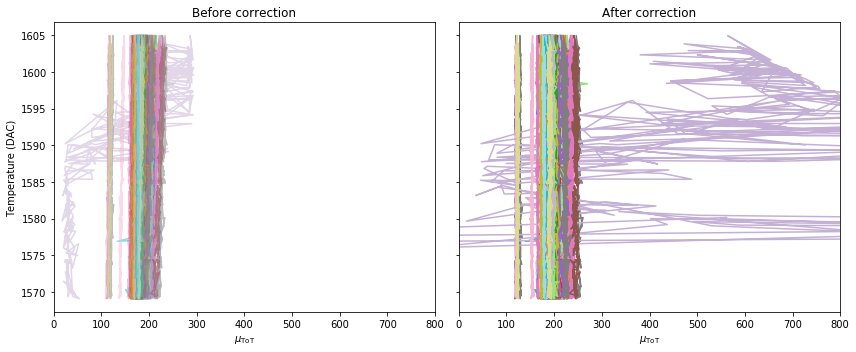

<Figure size 432x288 with 0 Axes>

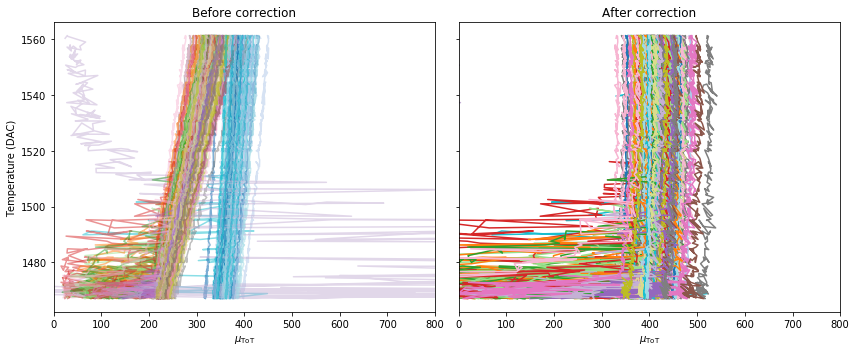

<Figure size 432x288 with 0 Axes>

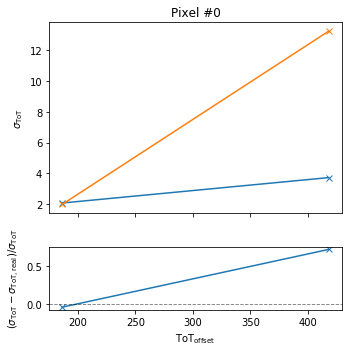

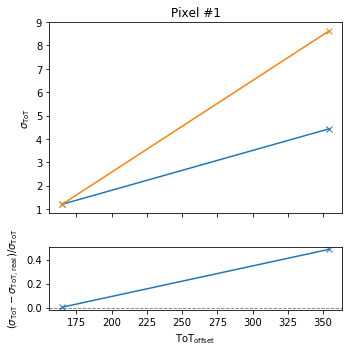

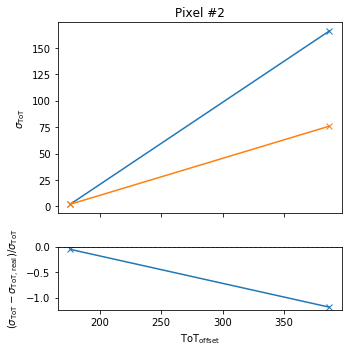

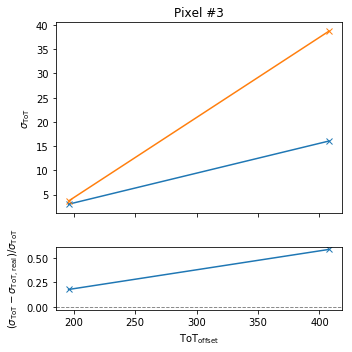

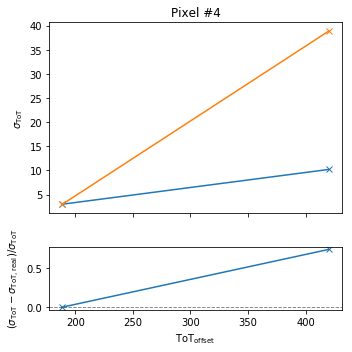

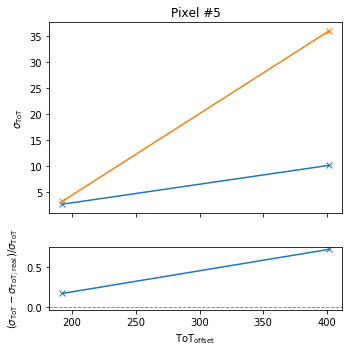

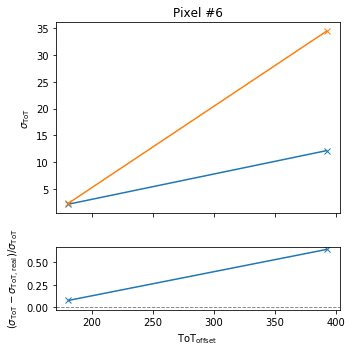

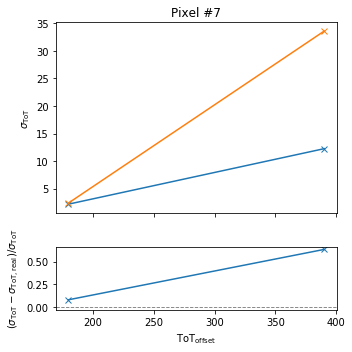

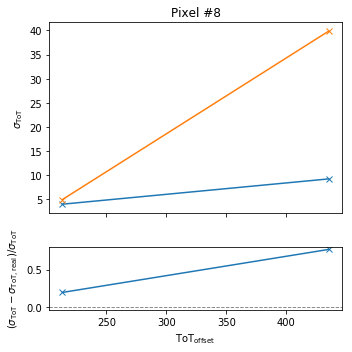

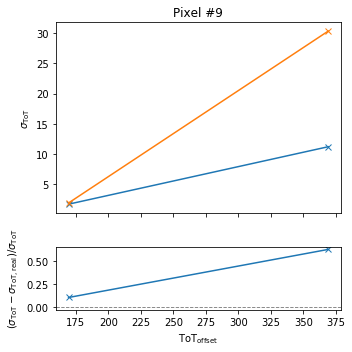

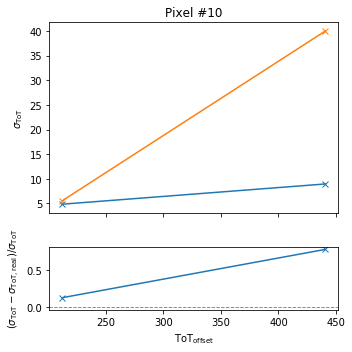

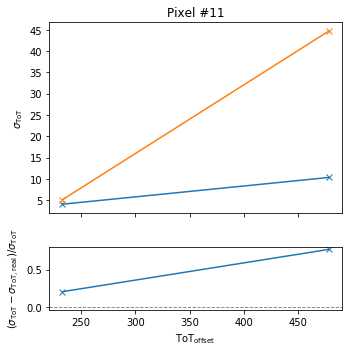

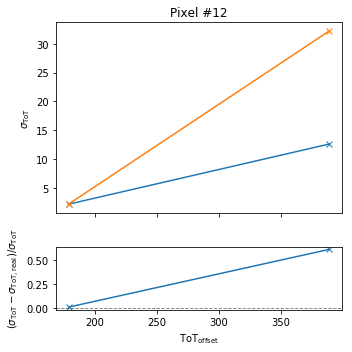

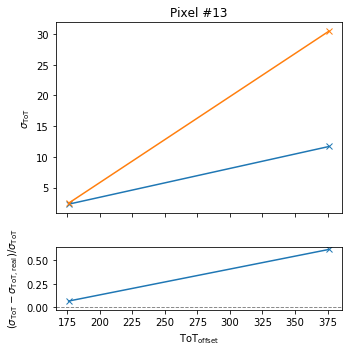

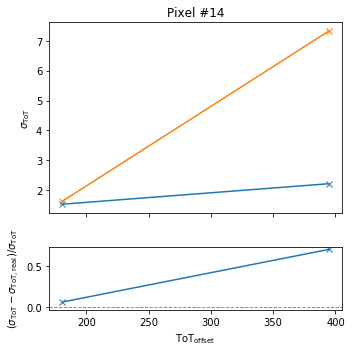

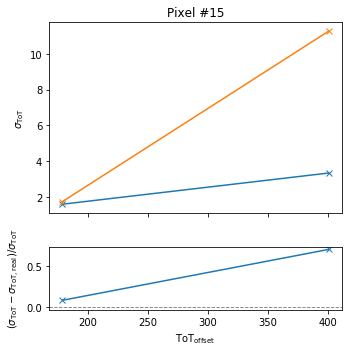

In [21]:
energyList = [25, 75] # , 125]
infileList = ['../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_%dkeV.hck' % energy for energy in energyList]

def combineFiles(infileList, energyList):
    # Get first file
    if infileList[0].endswith('.p'):
        d = cPickle.load(open(infileList[0], 'rb'))
    else:
        d = hickle.load(infileList[0])

    # Add energy column if needed
    if not 'energy' in d.keys():
        energy = energyList[0] * 1000
        d['energy'] = [energy]*len(d['time'])

    dim = min(len(d['energy']), len(d['ToT']), len(d['time']))
    for key in d.keys():
        d[key] = d[key][:dim]
        
    for idx, infile in enumerate(infileList[1:]):
        print infile
        if infileList[idx].endswith('.p'):
            d_ = cPickle.load(open(infile, 'rb'))
        else:
            d_ = hickle.load(infile)
                        
        if not 'energy' in d_.keys():
            energy = energyList[idx+1] * 1000
            d_['energy'] = [energy]*len(d_['time'])
            
        dim = min(len(d_['energy']), len(d_['ToT']), len(d_['time']))
        for key in d_.keys():
            d_[key] = d_[key][:dim]
            
        for key in d.keys():
            d[key] += list(d_[key])
            
    return d

temperatureDict = combineFiles(infileList, energyList)
roomTemp = 1635
outDict = pttt.plotTemperature(temperatureDict, offsettemp=1633, cuttemp=1520, plot=False, outdir='temperatureDPX22')
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']

## Bin Edges

In [279]:
binEdgesTh = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
        'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
        'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}

## Support Functions

In [4]:
def getNormalCounts(mu, sigma, a, b):
    return 0.5 * (scipy.special.erf((b - mu) / np.sqrt(2 * sigma**2)) - scipy.special.erf((a - mu) / np.sqrt(2 * sigma**2)))

def histMean(bins, hist):
    hist = np.nan_to_num(hist)
    bw = np.asarray(bins[:-1]) + 0.5 * np.diff(bins)
    mean = np.dot(bw, hist) / np.nansum(hist)
    return mean, np.sqrt(np.dot(hist/float(np.sum(hist)), np.square(np.asarray(bw) - mean)))

def ToTtoEnergy(data, params):
    pixelData = data
    # pixelData = pixelData[pixelData > 0]
    p = params
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']

    pixelDataEnergy = tte.ToTtoEnergy(pixelData, a, b, c, t, h, k)
    # pixelDataEnergy = pixelDataEnergy[np.logical_and(pixelDataEnergy > 10, pixelDataEnergy <= 100)]

    return pixelDataEnergy

def ToTatT(data, T, slope, offset, Toffset):
    data = np.asarray( data )
    # data = data[data > 0]
    dataAtT = pttt.getRealToT(data, T, Toffset, slope, offset)
    return dataAtT
    
def getDataAtT(data, T, slope, offset, Toffset, energy=True):
    dataEnergyList = []
    for idx in range(256):
        try:
            dataEnergy = getDataAtTSingle(data[idx], T, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=energy)
            dataEnergyList.append( dataEnergy )
        except:
            continue
    
    return dataEnergyList
    
def getDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True, rmZero=False):
    dataAtT = np.asarray( ToTatT(data, T, slope, offset, Toffset) )
    if rmZero:
        dataAtT = dataAtT[dataAtT > 0]
    # try:
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    # except:
    #     return None
    
    return dataEnergy

def simDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True):
    data = np.asarray(data)
    dataAtT = np.asarray( pttt.simWrongToT(data, T, Toffset, slope, offset) )
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    return dataEnergy

def linear(x, m, t):
    return m*x + t

def linear_rev(x, m, t):
    return (x - t) / m

def normal(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2/(s*sigma**2))

def alphaPolyShow(p, deg, x):
    resList = []
    p1, p2, p3 = deg
    idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

    for i in range(3):
        f = np.poly1d(np.asarray(p)[idxList[i]])
        resList.append( f(x) )

    return resList 

def alphaInt(x, y, edges):
    x = np.asarray(x)
    y = np.asarray(y)

    res = []
    for i in range(len(edges) - 1):
        # try:
        y_ = y[np.logical_and(x > edges[i], x <= edges[i+1])]
        x_ = x[np.logical_and(x > edges[i], x <= edges[i+1])]
        res.append( scipy.integrate.trapz(y_, x=x_) )
        # except:
        #    res.append( 0 )
        
    return res

## Conversion Factors

In [128]:
# Polynomial conversion factors
# polyParams = [-6.13432151e-09,  2.08479453e-06,  6.76750181e-10, -4.04786053e-07, 6.04542804e-05, 5.54387308e-09, -3.50905545e-06,  5.37851109e-04] 
# degs = [2, 3, 3]
polyParams = [-6.55543177e-08,  7.81132475e-06, -1.20790806e-04, -2.19105720e-07,
   1.26527393e-05, -2.83948881e-04, -3.90533778e-06,  1.42792858e-03] 
degs = [3, 3, 2]

# Detector names
titles = ['vac', 'al', 'sn']
x = binEdgesTh['al']
x_show = np.linspace(min(x), max(x), 10000)

# Split polynomial
p1, p2, p3 = degs
idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

# Get function to calculate binned conversion factors
fAlpha = []
for i in range(3):
    fAlpha.append( lambda x: np.abs( np.poly1d(np.asarray(polyParams)[idxList[i]])(x) ) )

## Example

In [ ]:
plt.step(x[:-1], y, where='post')
mean, std = histMean(binEdgesTh['al'], y)
plt.plot(x_show, normal(x_show, 1700, mean, std), color='C3')
print 'Mean:', mean, 'Std:', std

ax = plt.twinx()
ax.set_yscale("log", nonposy='clip')
# ax.plot(x_show, alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
ax.plot(x_show, fAlpha[1](x_show), color='C1')
plt.axvline(x=mean, ls='--', color='k')
alpha = fAlpha[1](np.asarray(binEdgesTh['al'])[:-1])
plt.step(x[:-1], alpha, where='post', color='C2')
print alpha

doseTrue = np.dot(y, alpha)
print 'Dose:', doseTrue
plt.xlim(0, 250)
plt.show()

# Transfer back to T0
plt.step(x[:-1], y_new, where='post')
mean, std = histMean(binEdgesTh['al'], y_new)

plt.axvline(x=mean, ls='--', color='k')
plt.step(linear_rev(np.asarray(x), 2., 1.)[:-1], y_new, where='post')

mean, std = histMean(linear_rev(np.asarray(binEdgesTh['al']), 2., 1.), y_new)
plt.plot(x_show, normal(x_show, 1700, mean, std), color='C3')
ax = plt.twinx()
ax.set_yscale("log", nonposy='clip')

# ax.step(linear(np.asarray(x), 2., 1.), alphaPoly, where='post', color='C1')
# ax.plot(linear(np.asarray(x_show), 2., 1.), alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
ax.plot(x_show, alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
alpha = alphaInt(x_show, alphaPolyShow(polyParams, degs, x_show)[1], linear_rev(np.asarray(binEdgesTh['al']), 2., 1.))
newEdges = {t: linear_rev(np.asarray(binEdgesTh[t]), 2., 1.) for t in titles}
print newEdges['al']
alpha = fAlpha[1](linear_rev(np.asarray(binEdgesTh['al']), 2., 1.)[:-1])
ax.step(linear_rev(np.asarray(x), 2., 1.)[:-1], alpha, where='post', color='C2')
plt.xlim(0, 250)

plt.axvline(x=mean, ls='--', color='k')
print 'Mean:', mean, 'Std:', std
doseRec = np.dot(y_new, alpha) # / np.asarray(x[:-1]))
print 'Dose:', doseRec
print doseRec / doseTrue
plt.show()

## Reconstruction Quality

In [6]:
def getDoseRate(x, y, y_new, titles, Toffset, TAdd, fAlpha, verbose=False, plot=False):
    doseRecList = []
    
    totalDose, totalDoseRec = 0, 0
    for i in range(3):
        mean, std = histMean(x[titles[i]], y[titles[i]])
        alpha = fAlpha[i](x[titles[i]][:-1])
        doseTrue = np.dot(y[titles[i]], alpha)
        totalDose += doseTrue
        if verbose:
            print 'Detector #%d' % (i + 1)
            print 'Mean1:', mean, 'Std1:', std
            print 'Dose1:', doseTrue

        # Transfer back to T0
        xToT = tte.EnergyToToT(x[titles[i]], p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])
        x_new = getDataAtTSingle(xToT, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
        mean, std = histMean(x_new, y_new[titles[i]])

        alpha = fAlpha[i](x_new[:-1])
        doseRec = np.dot(y_new[titles[i]], alpha)
        totalDoseRec += doseRec
        if verbose:
            print 'Mean2:', mean, 'Std2:', std
            print 'Dose2:', doseRec
            print 'Dose rate:', doseRec / doseTrue
            print
    
        doseRecList.append( doseRec / doseTrue )
    return doseRecList, float(totalDoseRec) / totalDose

## Reconstruction Evaluation

In [280]:
idx = 130
p = paramsDict[idx]
titles = ['vac', 'al', 'sn']
Toffset = 1635
TAdd = 9

doseRecList, totalDoseRecList = [], []
for mean in np.linspace(10, 100, 10):
    doseRecTemp, totalDoseRecTemp = [], []
    for sigma in np.linspace(5, 30, 10):
        # Use Al-only energy binning
        x = binEdgesTh
        
        # Generate random data
        # data = np.random.lognormal(mean=mean, sigma=sigma, size=10000)
        data_dict, data_temp_dict = {}, {}
        for t in titles:
            data = np.asarray( list(np.random.normal(mean, sigma, 10000)) + list(np.random.normal(0.5*mean, 0.5*sigma, 30000)) + list(np.random.uniform(16, 200, 20000)) )
            data = data[data > 16]
            data_hist, _ = np.histogram(data, bins=x[t])

            data_dict[t] = data_hist
            
            # Transform energy to ToT 
            dataToT = tte.EnergyToToT(data, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])
            # Apply temperature shift
            data_temp = simDataAtTSingle(dataToT, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
            data_temp_hist, _ = np.histogram(data_temp, bins=x[t])
            data_temp_dict[t] = data_temp_hist
        
        doseRec, totalDoseRec = getDoseRate(x, data_dict, data_temp_dict, titles, Toffset, TAdd, fAlpha)
        doseRecTemp.append( doseRec ), totalDoseRecTemp.append( totalDoseRec )
    doseRecList.append(doseRecTemp), totalDoseRecList.append(totalDoseRecTemp)

## Evaluation Results

[[0.9996238786914963, 1.0010776729045188, 0.9989690367312771], [1.0000876359886708, 1.0008146792302264, 0.9991162285730144], [1.000070876100896, 1.0004455792561693, 0.9993031191244581], [1.000199430196345, 1.0003503612544984, 0.9984763104114556], [1.0001162347052892, 1.0004359651486068, 0.9981410293809228], [0.9999984542421909, 1.0004445232393928, 0.9968697089308538], [1.0001538706695827, 1.0006019842040057, 0.9961115163523796], [1.0000419608376392, 1.0006206520451884, 0.9952183653851379], [0.9999361831156741, 1.00054390747294, 0.9953499682768445], [1.0001212082954405, 1.0005003607584506, 0.9940254815360119]]


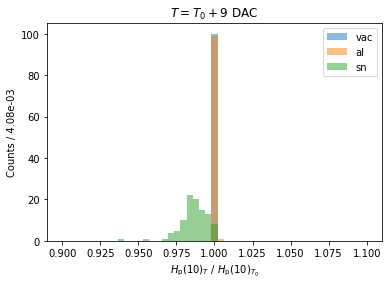

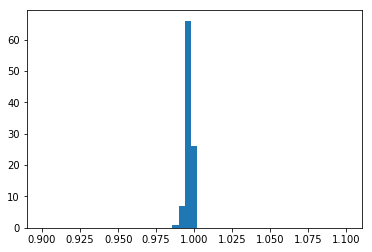

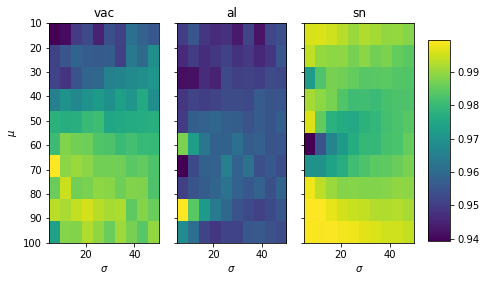

Text(0,0.5,'$\\mu$')

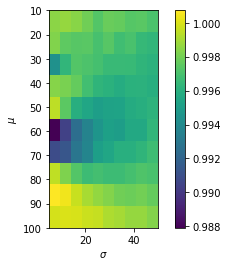

In [281]:
print doseRecList[-1]

# Distributions for each detector
bins = np.linspace(0.9, 1.1, 50)
for i in range(3):
    plt.hist(np.asarray(doseRecList)[:,:,i].flatten(), bins=bins, alpha=.5, label=titles[i])
plt.legend()
plt.xlabel('$H_\mathrm{p}$(10)$_{T}$ / $H_\mathrm{p}$(10)$_{T_0}$')
plt.ylabel('Counts / %.2e' % (bins[1] - bins[0]))
plt.title('$T = T_0' + (' + ' if TAdd > 0 else ' - ') + '%d$ DAC' % TAdd)
plt.show()

# Distribution of total dose
plt.hist(np.asarray(totalDoseRecList).flatten(), bins=bins)
plt.show()

fig, ax = plt.subplots(1, 3, sharey=True)
for i in range(3):
    im = ax[i].imshow(np.asarray(doseRecList)[:,:,i], extent=(5, 50, 100, 10))
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('$\sigma$')
ax[0].set_ylabel('$\mu$')
cbar_ax = fig.add_axes([1., 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()

plt.imshow(totalDoseRecList, extent=(5, 50, 100, 10))
plt.colorbar()
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

# Am-Heating Measurement (DPX22)

In [7]:
import ToTtoEnergy as tte

# measDir = '../../dpx_data/ToTAmHeating_DPX22/' 
measDir = '../../dpx_data/ToTAmHeating_DPX22/' 
tempFile = measDir + 'ToTMeasurement_temp.hck'
totFile = measDir + 'ToTMeasurement.hck'

In [156]:
# Attention: redefinition of tempDict
tempDict = hickle.load(tempFile)
totDict = hickle.load(totFile)
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')

## Temperature

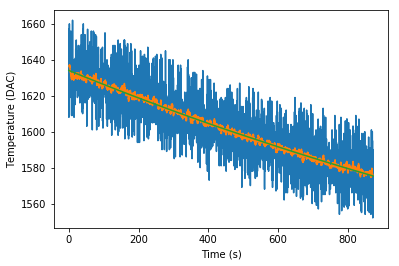

In [201]:
def tempDecay(x, A, T, c):
    return A*np.exp(-x/T) + c

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(tempDict['time'], tempDict['temp'])
# tempFilt = scipy.signal.savgol_filter(tempDict['temp'], 151, 3)

NFilt = 30
tempFilt = running_mean(tempDict['temp'], NFilt)
plt.plot(tempDict['time'][NFilt//2:-NFilt//2+1], tempFilt)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (DAC)')

popt, pcov = scipy.optimize.curve_fit(tempDecay, np.arange(len(tempDict['time'])), tempDict['temp'])
plt.plot(tempDict['time'], tempDecay(np.arange(len(tempDict['time'])), *popt))

In [158]:
def dataToHist(data, discardPixel=[]):
    histDict = {'bins': [], 'hist': []}
    for pixel, d in enumerate(data):
        if pixel in discardPixel:
            histDict['bins'].append(None), histDict['hist'].append(None)
            continue

        d = np.asarray(d)
        d = d[d > 0]
        if len(d) == 0 or len(set(d)) == 1:
            hist, bins = None, None
        else:
            # try:
            hist, bins = np.histogram(d, bins=int(max(d) - min(d)))
            # except:
            #    hist, bins = None, None
            #    pass
        histDict['bins'].append(bins), histDict['hist'].append(hist)
        
    return histDict

## Temperature Correction

In [11]:
data = 0.88 * np.asarray(totDict['Slot1']).T

data_temp_corr = []
for pixel in range(256):
    print pixel,
    d = data[pixel]
    d = np.ma.array(d, mask=~(d > 0))
    real_d = np.asarray([pttt.getRealToT(d[i], tempDecay(i, *popt), outDict['Toffset'], slope[pixel], offset[pixel]) for i in range(len(d))])
    data_temp_corr.append( real_d[~np.isnan(real_d)] )

0

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


 1

KeyboardInterrupt: 

In [30]:
fn = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_complete.hck')
# fn = hickle.load('../../dpx_data/ToTMeasurement_7_total.hck')
# fn = hickle.load('../../dpx_data/Measurements/DPX6/ToTMeasurementHist_AmSn4.hck')

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


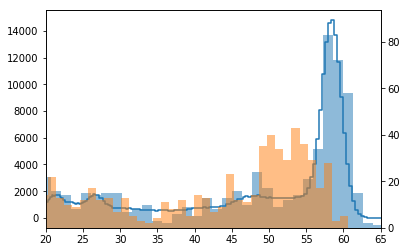

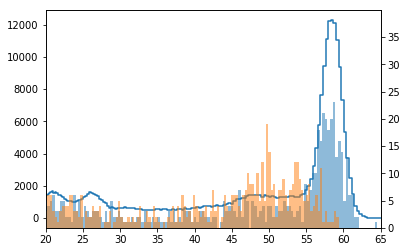

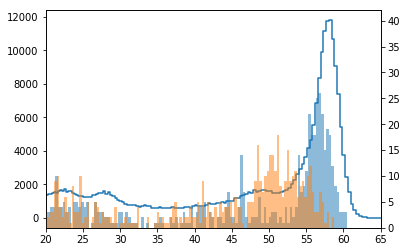

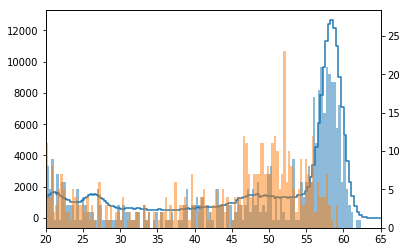

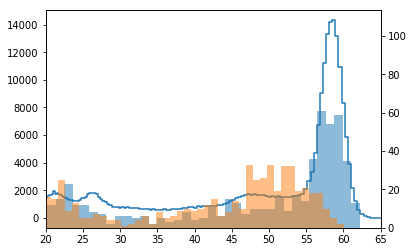

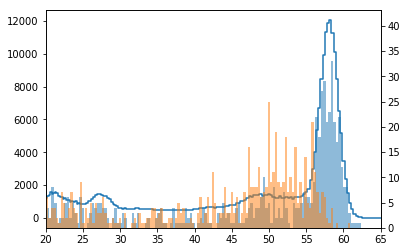

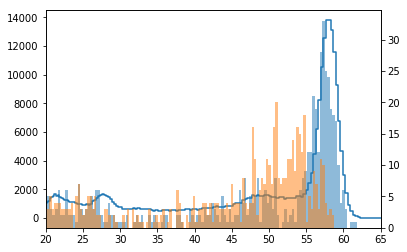

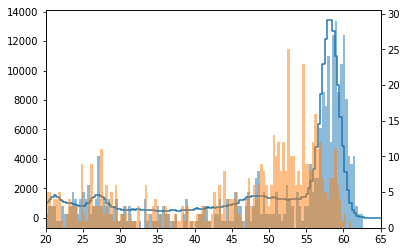

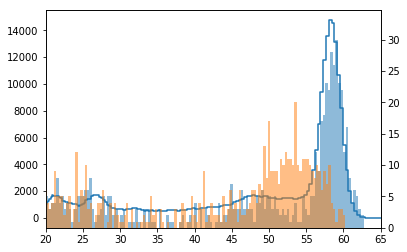

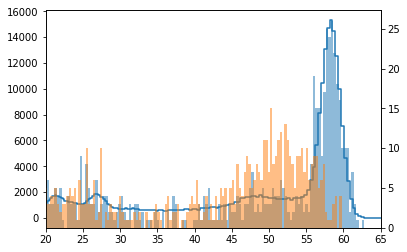

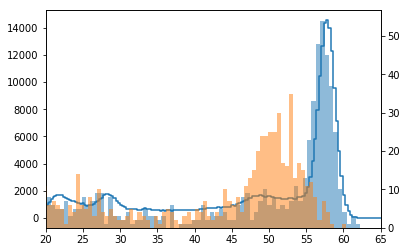

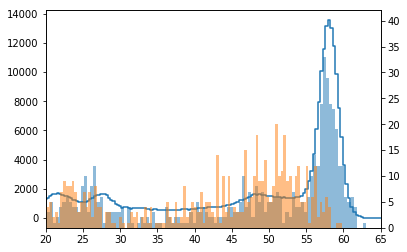

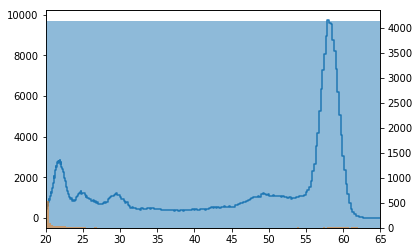

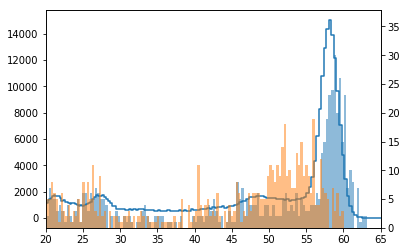

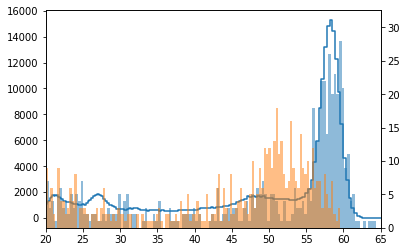

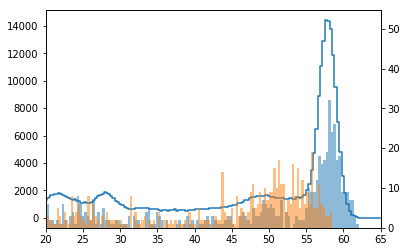

In [31]:
# idxRange = [8 + i*16 for i in range(13, 16)]
SHOW_ENERGY = True
SHOW_FAC = 1.

idxRange = [7 + i*16 for i in range(16)]
for idx in idxRange:
    # Energy conversion
    p = paramsDict[idx]
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
    
    if SHOW_ENERGY:
        fn_bins = tte.ToTtoEnergy(fn['bins'][idx][:-1], a, b, c, t, h, k)
    else:
        fn_bins = fn['bins'][idx][:-1]
    plt.step(fn_bins, fn['hist'][idx], where='post')
    ax = plt.twinx()
    d = 0.88 * np.asarray(totDict['Slot1']).T[idx]
    len_d = len(d)
    d = np.ma.array(d, mask=~(d > 0))[:int(SHOW_FAC*len_d)]

    # Temperature correction
    real_d = np.asarray([pttt.getRealToT(d[i], tempDecay(i, *popt), outDict['Toffset'], slope[idx], offset[idx]) for i in range(len(d))])
    len_real_d = len(real_d)
    real_d = real_d[~np.isnan(real_d)][:int(SHOW_FAC*len_real_d)]

    if SHOW_ENERGY:
        real_d_energy = tte.ToTtoEnergy(real_d, a, b, c, t, h, k)
        ax.hist(real_d_energy, bins=150, alpha=.5)
        ax.hist(tte.ToTtoEnergy(d, a, b, c, t, h, k), bins=150, alpha=.5)
    else:
        ax.hist(real_d, bins=150, alpha=.5)
        ax.hist(d, bins=150, alpha=.5)

    # a, b = 0, int(0.1*len(d))# , len(d)
    # real_d = pttt.getRealToT(d[a:b], 1630, 1560, slope[idx], offset[idx])

    plt.xlim(20, 65)
    plt.show()

In [ ]:
reload(tte)
discardPixel = [] # [28, 29, 30, 106, 199, 243]

histDict = dataToHist(np.asarray(data_temp_corr), discardPixel=discardPixel)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

data = np.asarray(0.88*np.asarray(totDict['Slot1'])).T
histDict = dataToHist(data, discardPixel=discardPixel)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

In [ ]:
reload(tte)
discardPixel = [] # [30, 106, 199, 243]
for i in range(30):
    data = 0.88 * np.asarray( totDict['Slot1'] )[i * 300:(i+1) * 300].T
    print data.shape
    histDict = dataToHist(data, discardPixel=discardPixel)
    tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

## Dose Measurement

In [293]:
# Bin measurement data
data = 0.88 * np.asarray(totDict['Slot1']).T
titles = ['vac', 'al', 'sn']
final_time = int(tempDict['time'][-1]) - 100
time_step = 60

histDict = {}
doseDict, doseCorrDict = {}, {}
for tit_idx, tit in enumerate(titles):
    pixelDict = {}
    pixelDose, pixelCorrDose = [], []
    for pixel in range(256):
        if not pixel in paramsDict.keys():
            continue
        p = paramsDict[pixel]
        a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
        bins_tot = tte.EnergyToToT(np.asarray(binEdgesTh[tit]), a, b, c, t, h, k)
        if not (bins_tot == np.sort(bins_tot)).all():
            continue

        timeDict = {}
        timeDose, timeCorrDose = [], []
        for time in np.arange(0, final_time, time_step):
            time_args = np.argwhere(np.logical_and(tempDict['time'] > time, tempDict['time'] <= time + time_step)).flatten()
            data_time = data[pixel][time_args]
            h = np.histogram(data_time, bins=bins_tot)[0]
            timeDict[time] = h
            
            # Get dose
            dose = np.dot(h, fAlpha[tit_idx](binEdgesTh[tit])[:-1])
            
            # Get corrected dose
            time_idx = np.argmin(np.abs(time - tempDict['time'])), np.argmin(np.abs((time + time_step) - tempDict['time']))
            temperature = tempDecay(time_idx[1], *popt) # 0.5 * np.sum([tempDecay(elm, *popt) for elm in time_idx])
            
            bins_corr_energy = getDataAtTSingle(bins_tot[:-1], temperature, slope[pixel], offset[pixel], outDict['Toffset'], p, energy=True)
            # if tit == 'sn':
            #    print bins_corr_energy
        
            doseCorr = np.dot(h, fAlpha[tit_idx](bins_corr_energy))
            timeDose.append( dose ), timeCorrDose.append( doseCorr )
            
        pixelDict[pixel] = timeDict
        pixelDose.append( timeDose ), pixelCorrDose.append( timeCorrDose )
    histDict[tit] = pixelDict
    doseDict[tit], doseCorrDict[tit] = pixelDose, pixelCorrDose

# getDoseRate(x, y, y_new, titles, Toffset, TAdd, fAlpha, verbose=False, plot=False)

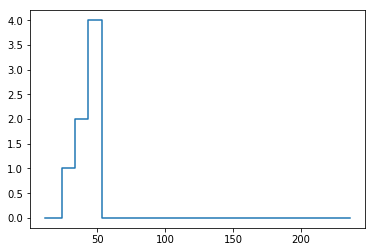

In [302]:
plt.step(binEdgesTh['vac'][:-1], histDict['vac'][8][600], where='post')

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770]
[0.006177635075311969, 0.008767842896519173, 0.007512034313613905, 0.011345175916991627, 0.01264324514650108, 0.0012169600640782997, 0.011305759960215597, 0.006238572812701092, 0.006204758353372671, 0.011213100844705524, 0.005025018189112406, 0.007452402482972734, 0.007444215653506926, 0.0036401361601203124, 0.008782387180428758, 0.006384412930579737, 0.006180245307807504, 0.009692402455031942, 0.003633281593491576, 0.003759715596426053, 0.0062191805050397075, 0.006133024025547288, 0.015013194512219694, 0.002540974999385686, 0.004963508039830317, 0.003668504600569205, 0.0024147497872531567, 0.009791011163660044, 

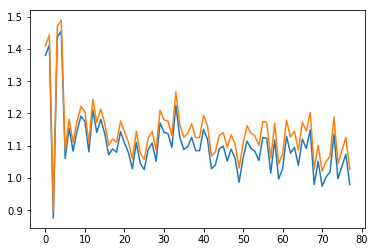

In [295]:
print sorted( histDict['vac'][4].keys() )
print doseCorrDict['vac'][0], doseCorrDict['vac'][-1]
print doseDict['vac'][0], doseDict['vac'][-1]
print np.count_nonzero(~np.isnan(doseCorrDict['vac']))
print np.count_nonzero(~np.isnan(doseCorrDict['vac']), axis=0)
print np.nansum(doseCorrDict['sn'], axis=0)
plt.plot(np.nansum(doseCorrDict['sn'], axis=0) * 182. / np.count_nonzero(~np.isnan(doseCorrDict['sn']), axis=0))
plt.plot(np.sum(doseDict['sn'], axis=0))

Text(0,0.5,'Response')

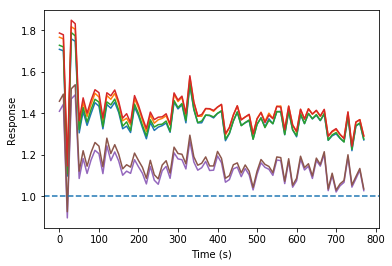

In [301]:
for t in titles:
    doses = np.asarray(doseDict[t])
    doses_corr = np.asarray(doseCorrDict[t]) * 182 / 176
    # plt.imshow(doses_corr)
    # plt.show()
    plt.plot(sorted(histDict[t][6].keys()), np.sum(doses, axis=0)) # / np.sum(doses, axis=0)[0])
    plt.plot(sorted(histDict[t][6].keys()), np.nansum(doses_corr, axis=0)) # / (np.nansum(doses_corr, axis=0)[0]))

plt.axhline(y=1, ls='--')
plt.xlabel('Time (s)')
plt.ylabel('Response')

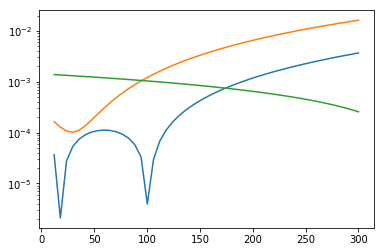

In [210]:
x_show = np.linspace(12, 300)
for i in range(3):
    plt.semilogy(x_show, fAlpha[i](x_show))